# HOPFIELD NET

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

### HopfieldNet

In [8]:
# train matrix with pattern list

class HopfieldNet:

    def __init__(self, n_neurons: int):
        self.n = n_neurons
        self.W = np.zeros((n_neurons, n_neurons))

    def train_hebb(self, patterns):
        patterns = np.array(patterns)
        self.W = np.zeros((self.n, self.n))
        for p in patterns:
            self.W += np.outer(p, p)

        np.fill_diagonal(self.W, 0)
        self.W /= len(patterns)

    def train_oja_symmetric(self, patterns, eta=0.01, epochs=50):
        patterns = np.array(patterns)
        W = np.random.randn(self.n, self.n) * 0.01 
        np.fill_diagonal(W, 0)

        for _ in range(epochs):
            for x in patterns:
                y = W @ x
                dW = eta * (np.outer(y, x) - np.outer(y, y) @ W)
                W += dW
            # TODO tutaj kurwa nie wiem czy to jest ok rozumiem update wag ale te fill i normalizacja smierdzi
            W = 0.5 * (W + W.T)

        np.fill_diagonal(W, 0)
        self.W = W

    @staticmethod
    def oja_matrix_update(W, x, eta=0.01):
        y = W @ x 
        W += eta * (np.outer(y, x) - np.outer(y, y) @ W)
        return W

    # zwykł np.sign dla zera zwraca 0
    @staticmethod
    def sign(x):
        # return np.sign(x)
        return np.where(x >= 0, 1, -1)

    def update_sync(self, state):
        return self.sign(self.W @ state)
    
    def energy(self, state):
        return -0.5 * state.T @ self.W @ state
    
    def run_single(self, state):
        return self.sign(self.W @ state)
    
    def run_sync(self, state, max_iter=20):
        history = [state.copy()]
        for _ in range(0,max_iter):
            new_state = self.sign(self.W @ state)
            history.append(new_state.copy())
            if np.array_equal(new_state, state):
                break
            state = new_state

        return state, history
    def run_async(self, state, max_iters=20):
        history = [state.copy()]
        s = state.copy()
        n = len(s)
        for _ in range(max_iters):
            changed = False
            idxs = np.random.permutation(n)
            for i in idxs:
                h_i = self.W[i] @ s
                new_val = 1 if h_i >= 0 else -1
                if new_val != s[i]:
                    changed = True
                    s[i] = new_val

            history.append(s.copy())
            # jesli zaden neuron nie zmienil sie w epoce to stop
            if not changed:
                break
            
        return s, history

### Wizualizacje

In [9]:

def basic_plot(pattern, height, width):
    img = pattern.reshape(height, width)
    plt.imshow(img, cmap="gray")
    plt.show()

def plot_triplet(
    original,
    noisy,
    recovered,
    height,
    width,
    first_title="Original",
    second_title="Noisy",
    third_title="Recovered",
):
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))

    axes[0].imshow(original.reshape(height, width), cmap="gray")
    axes[0].set_title(first_title)
    axes[0].axis("off")

    axes[1].imshow(noisy.reshape(height, width), cmap="gray")
    axes[1].set_title(second_title)
    axes[1].axis("off")

    axes[2].imshow(recovered.reshape(height, width), cmap="gray")
    axes[2].set_title(third_title)
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()


def plot_iterations(images, height, width, cols=5):
    n = len(images)
    rows = int(np.ceil(n / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))

    if rows == 1:
        axes = np.array([axes])

    for i, img in enumerate(images):
        r = i // cols
        c = i % cols
        ax = axes[r, c]

        img_to_show = img.reshape(height, width)

        ax.imshow(img_to_show, cmap="gray")
        ax.set_title(f"Iter {i}")
        ax.axis("off")

    for i in range(n, rows * cols):
        r = i // cols
        c = i % cols
        axes[r, c].axis("off")

    plt.tight_layout()
    plt.show()

### Funkcje pomocnicze

In [10]:
def basic_noise(pattern, nums_neurons, noise_level):
    noisy = pattern.copy()
    idx = np.random.choice(nums_neurons, int(nums_neurons * noise_level), replace=False)
    noisy[idx] *= -1
    return noisy

### Data

In [11]:
# load data and set sizes
data_set_list = [
    "animals-14x9.csv",
    "large-25x25.csv",
    "large-25x25.plus.csv",
    "large-25x50.csv",
    "letters-14x20.csv",
    "letters-abc-8x12.csv",
    "OCRA-12x30-cut.csv",
    "small-7x7.csv",
]

vecs = np.loadtxt(f"data/{data_set_list[0]}", delimiter=",")

# tricky w niektrórych zbiorach dlatego ustawiane ręcznie
height = 9
width = 14
nums_neurons = height * width

### Basic flow

In [12]:
net_hopfield = HopfieldNet(nums_neurons)

In [13]:
# choose image
indx = 2

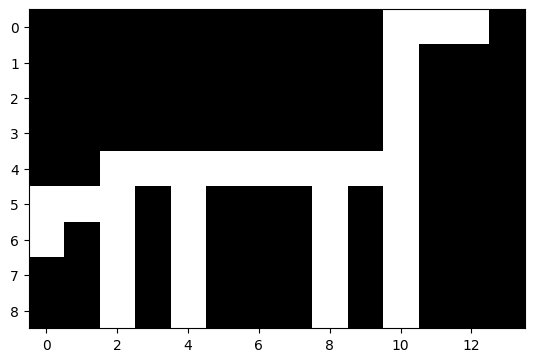

In [14]:
basic_plot(vecs[indx], height, width)

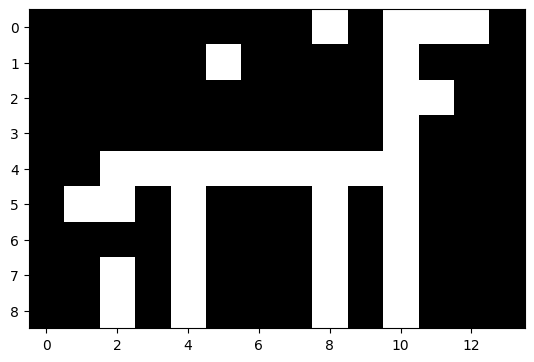

In [15]:
# basic noise
noise_level = 0.05
noisy = basic_noise(vecs[indx], nums_neurons, noise_level)
basic_plot(noisy, height, width)

energy original: -1783.9999999999993
energy single: -1907.9999999999998
energy recovered: -2078.666666666667
energy recovered async : -2078.666666666667


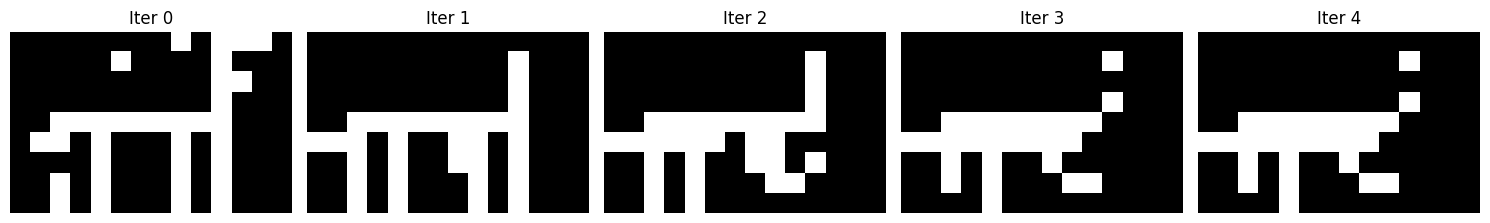

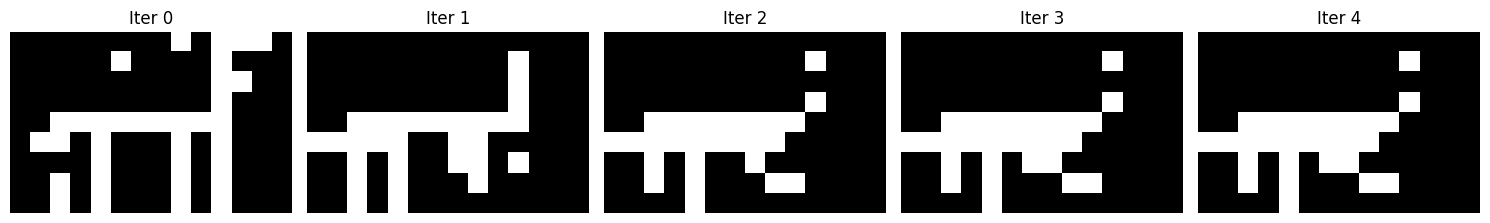

In [16]:
net_hopfield.train_hebb(vecs)
recovered, history_run = net_hopfield.run_sync(noisy)
recovered_single = net_hopfield.run_single(noisy)
recovered_async, history_async_run = net_hopfield.run_async(noisy)

print("energy original:", net_hopfield.energy(vecs[indx]))
print("energy single:", net_hopfield.energy(recovered_single))
print("energy recovered:", net_hopfield.energy(recovered))
print("energy recovered async :", net_hopfield.energy(recovered_async))


plot_iterations(history_run, height, width)
plot_iterations(history_async_run, height, width)

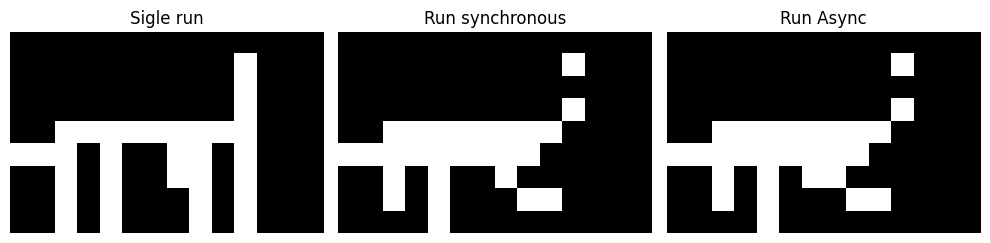

In [17]:
plot_triplet(recovered_single, recovered, recovered_async, height, width, "Sigle run", "Run synchronous", "Run Async")

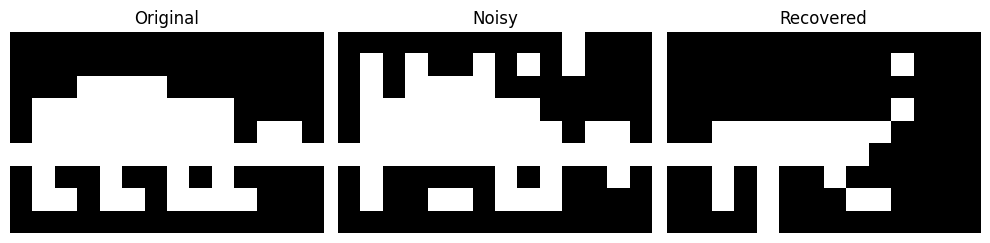

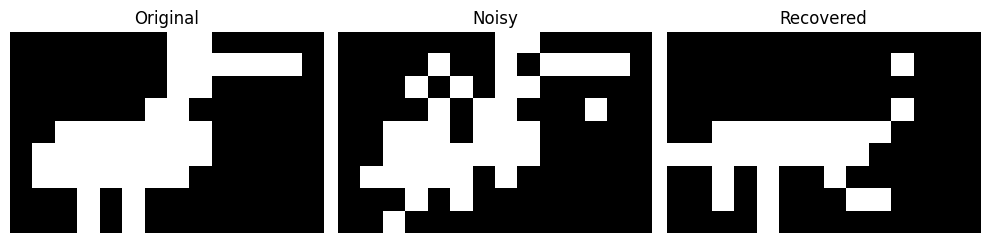

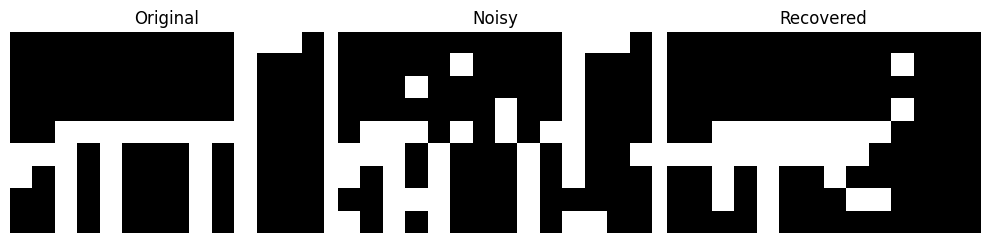

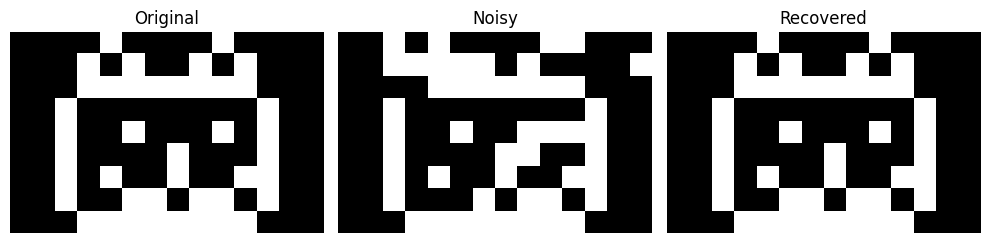

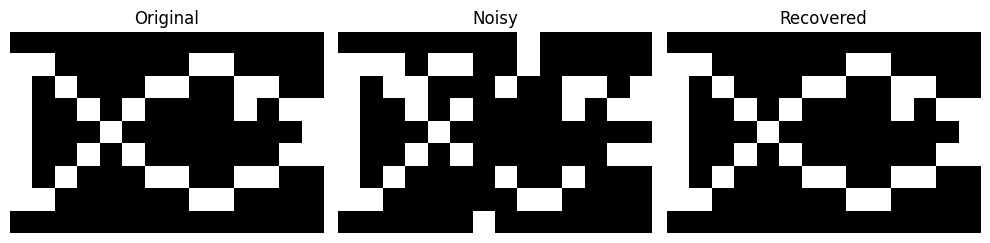

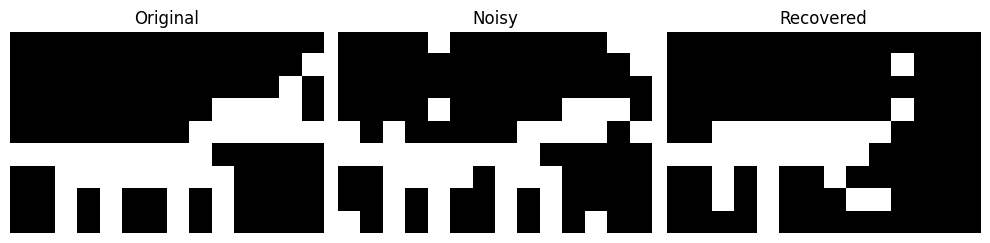

In [18]:
for vec in vecs:
    noisy = basic_noise(vec, nums_neurons, 0.1)
    recovered, _ = net_hopfield.run_sync(noisy)
    plot_triplet(vec, noisy, recovered, height, width)

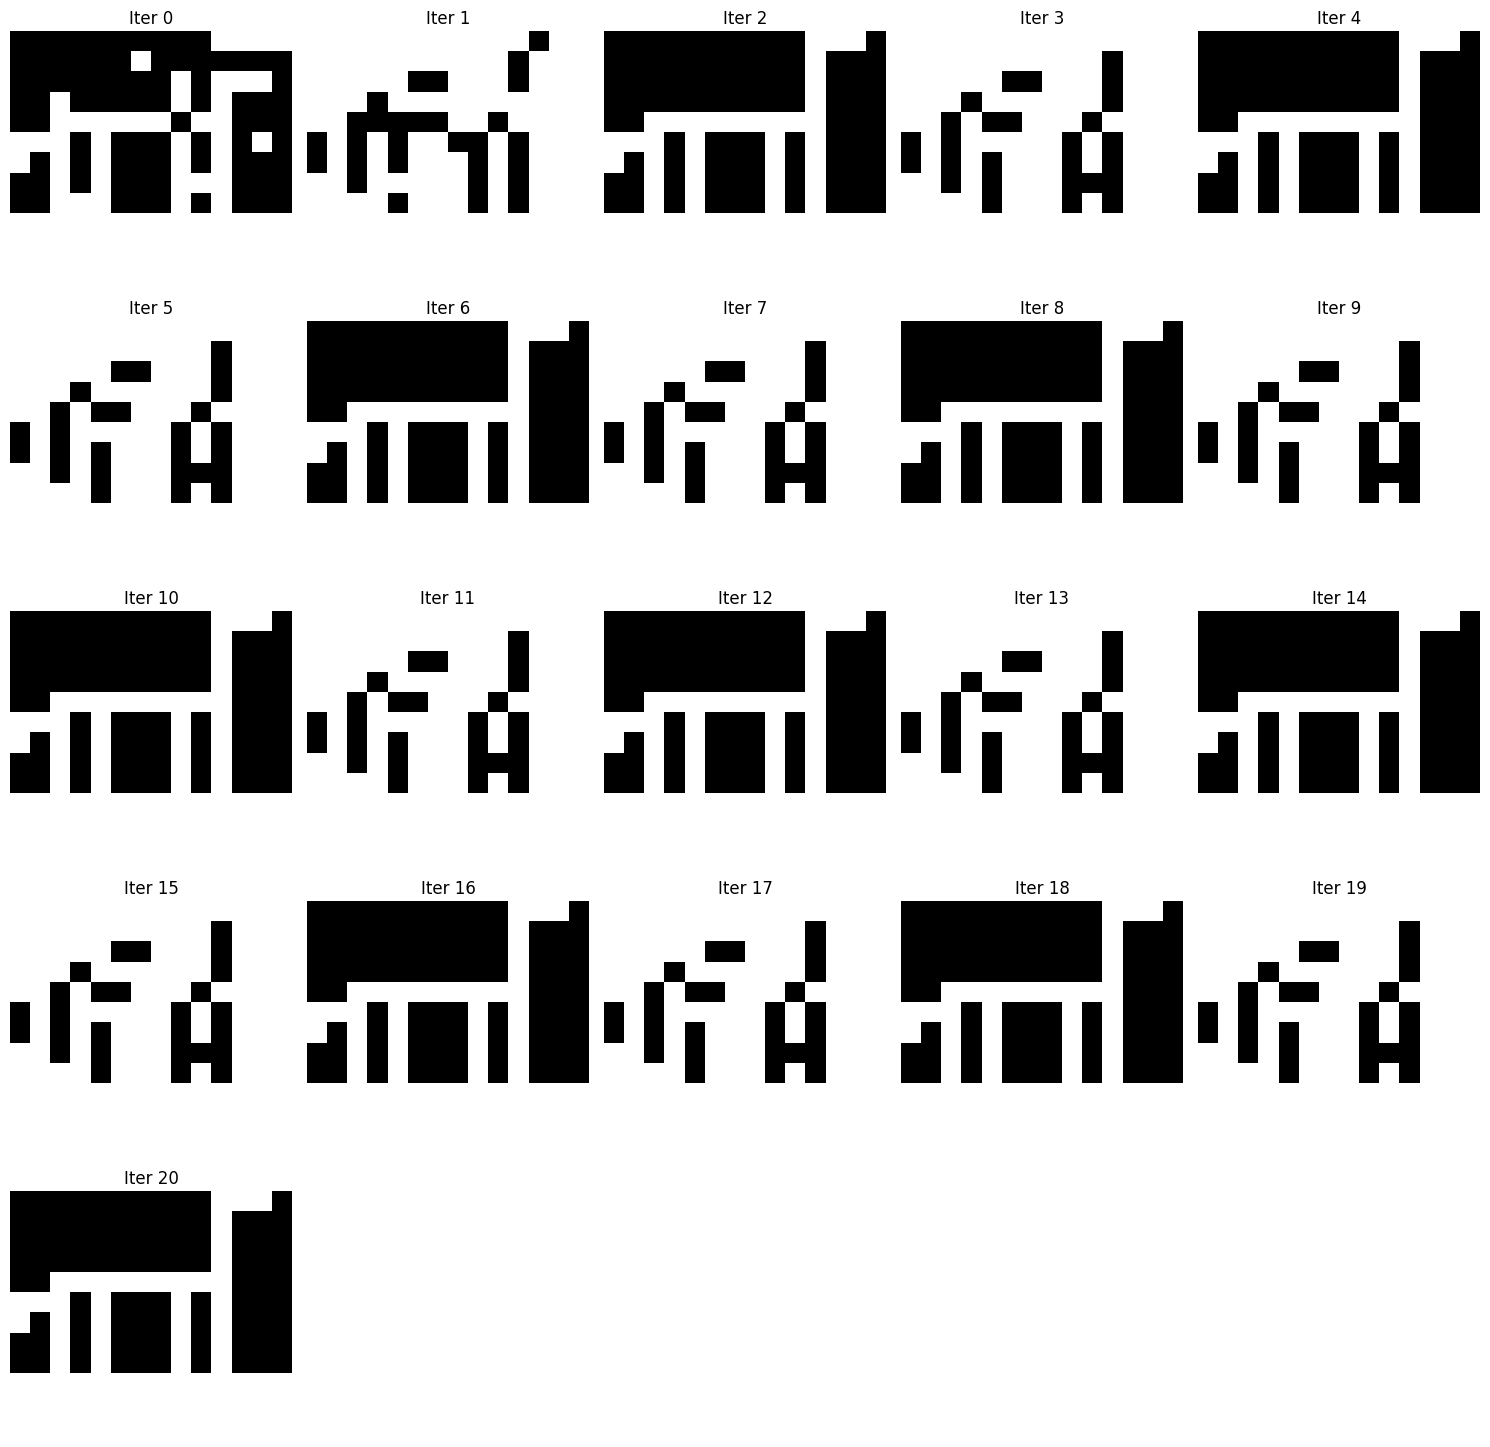

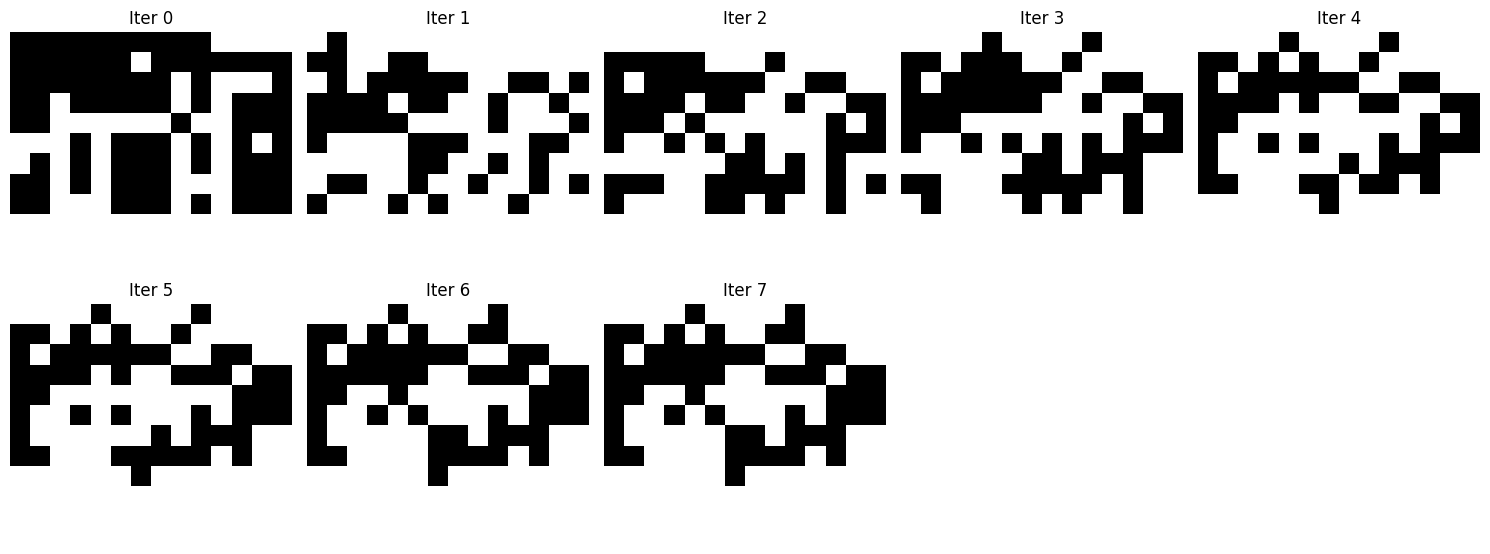

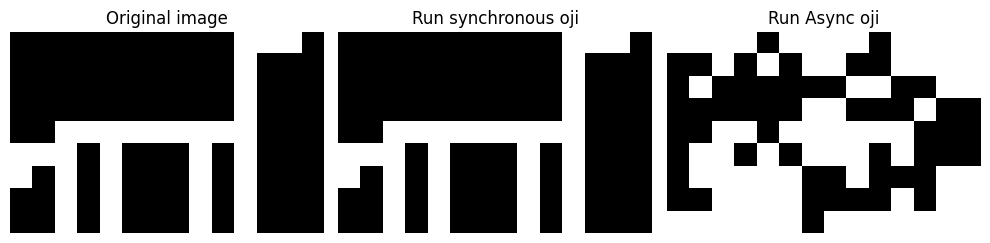

In [19]:
net_oja = HopfieldNet(nums_neurons)
net_oja.train_oja_symmetric(vecs, eta=0.001, epochs=200)
noisy = basic_noise(vecs[indx], nums_neurons, noise_level=0.1)
recovered, history_run = net_oja.run_sync(noisy)
recovered_async, history_async_run = net_oja.run_async(noisy)
plot_iterations(history_run, height, width)

plot_iterations(history_async_run, height, width)

plot_triplet(
    vecs[indx],
    recovered,
    recovered_async,
    height,
    width,
    "Original image",
    "Run synchronous oji",
    "Run Async oji",
)

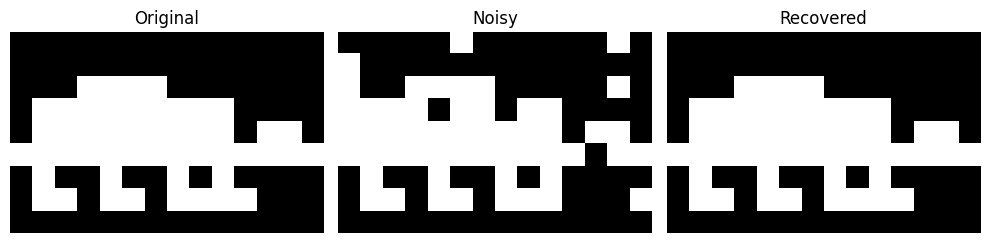

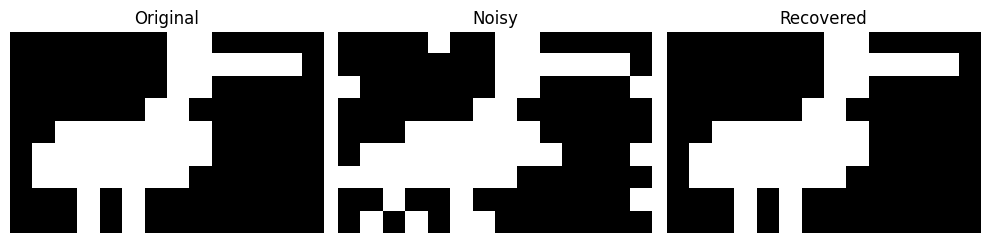

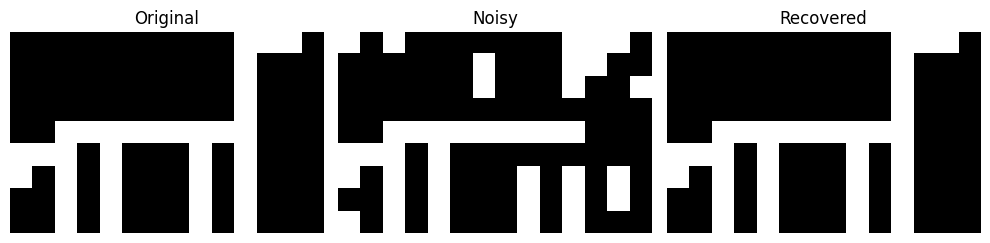

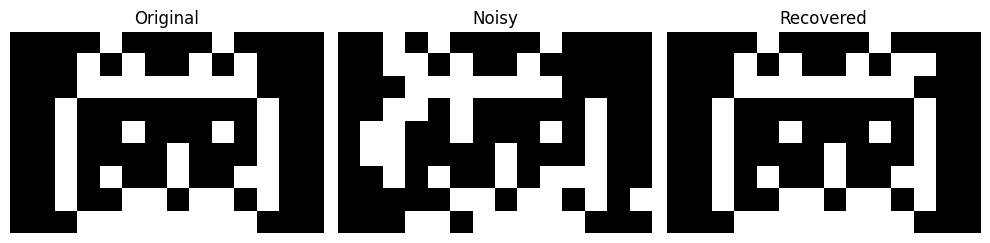

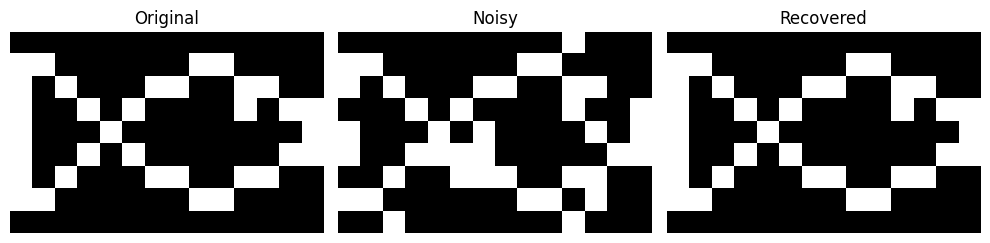

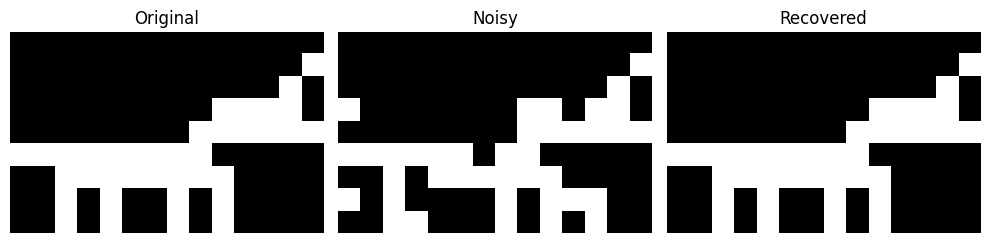

In [20]:
# have better capacity than hebb rule
for vec in vecs:
    noisy = basic_noise(vec, nums_neurons, 0.1)
    recovered, _ = net_oja.run_sync(noisy)
    plot_triplet(vec, noisy, recovered, height, width)

# EXPERIMENTS


### 1. Noise level

In [26]:
def recall_success(net, patterns, noise=0, iters=20):
    ok = 0
    for p in patterns:
        noisy = p
        if noise != 0:
            noisy = basic_noise(p, len(p), noise)
            
        rec, _ = net.run_sync(noisy, max_iter=iters)
        if np.array_equal(rec, p):
            ok += 1
    return ok / len(patterns)


net_oja = HopfieldNet(nums_neurons)
net_oja.train_oja_symmetric(vecs, eta=0.001, epochs=200)

noise_levels = [0.05, 0.1, 0.2, 0.3, 0.4]

net_hebb = HopfieldNet(nums_neurons)
net_hebb.train_hebb(vecs)

for nl in noise_levels:
    rate = recall_success(net_hopfield, vecs[:5], nl)
    print(f"Hebb Noise={nl}, recall={rate:.2f}")
    rate = recall_success(net_oja, vecs[:5], nl)
    print(f"Oji Noise={nl}, recall={rate:.2f}")

Hebb Noise=0.05, recall=0.20
Oji Noise=0.05, recall=0.80
Hebb Noise=0.1, recall=0.20
Oji Noise=0.1, recall=0.80
Hebb Noise=0.2, recall=0.20
Oji Noise=0.2, recall=0.80
Hebb Noise=0.3, recall=0.20
Oji Noise=0.3, recall=0.80
Hebb Noise=0.4, recall=0.20
Oji Noise=0.4, recall=0.40


### 2. Stability

In [30]:
sizes = [1, 3, 5, 6]
for s in sizes:
    subset = vecs[:s]
    net_hopfield.train_hebb(subset)
    net_oja.train_oja_symmetric(subset)
    stab = recall_success(net_hopfield, subset)
    stab_oja = recall_success(net_oja, subset)
    print(f"Hebb P = {s}, stability = {stab:.2f}")
    print(f"Oji P = {stab_oja}, stability = {stab_oja:.2f}")

Hebb P = 1, stability = 1.00
Oji P = 1.0, stability = 1.00
Hebb P = 3, stability = 1.00
Oji P = 1.0, stability = 1.00
Hebb P = 5, stability = 0.80
Oji P = 1.0, stability = 1.00
Hebb P = 6, stability = 0.33
Oji P = 1.0, stability = 1.00


### 3. Oji vs Hebb (copy from above)

In [31]:
subset = vecs

net_hopfield.train_hebb(subset)
net_oja.train_oja_symmetric(subset, eta=0.001, epochs=200)

noise = 0.1

hebb_rate = recall_success(net_hopfield, subset, noise)
oja_rate = recall_success(net_oja, subset, noise)

print("Hebb recall:", hebb_rate)
print("Oja recall:", oja_rate)

Hebb recall: 0.3333333333333333
Oja recall: 1.0


### 4. Random input 

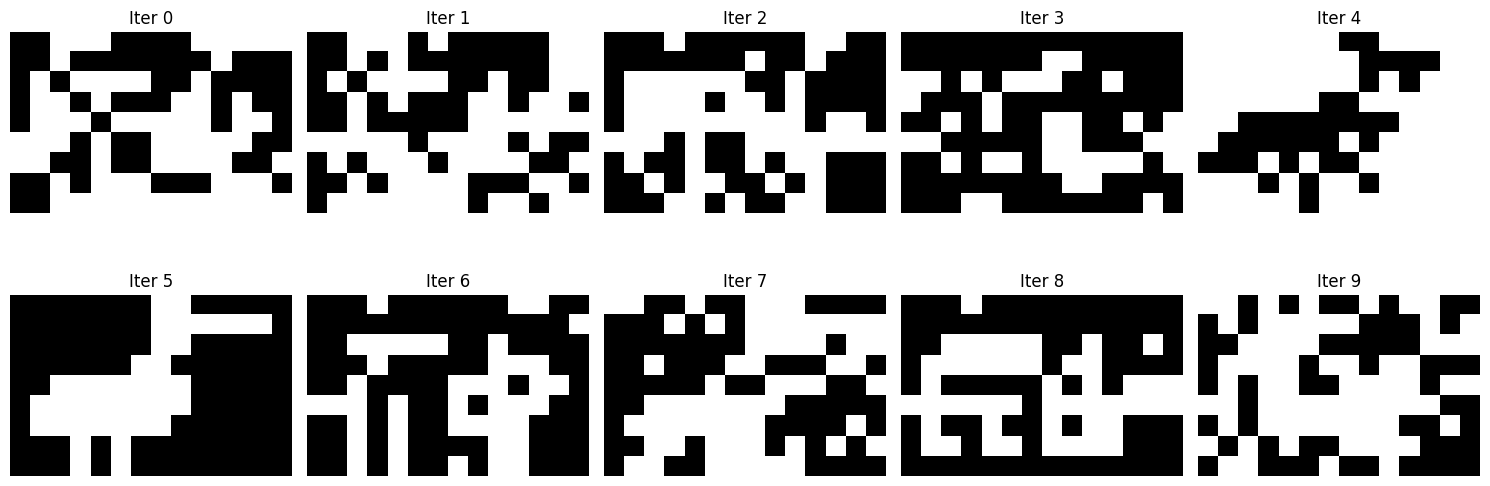

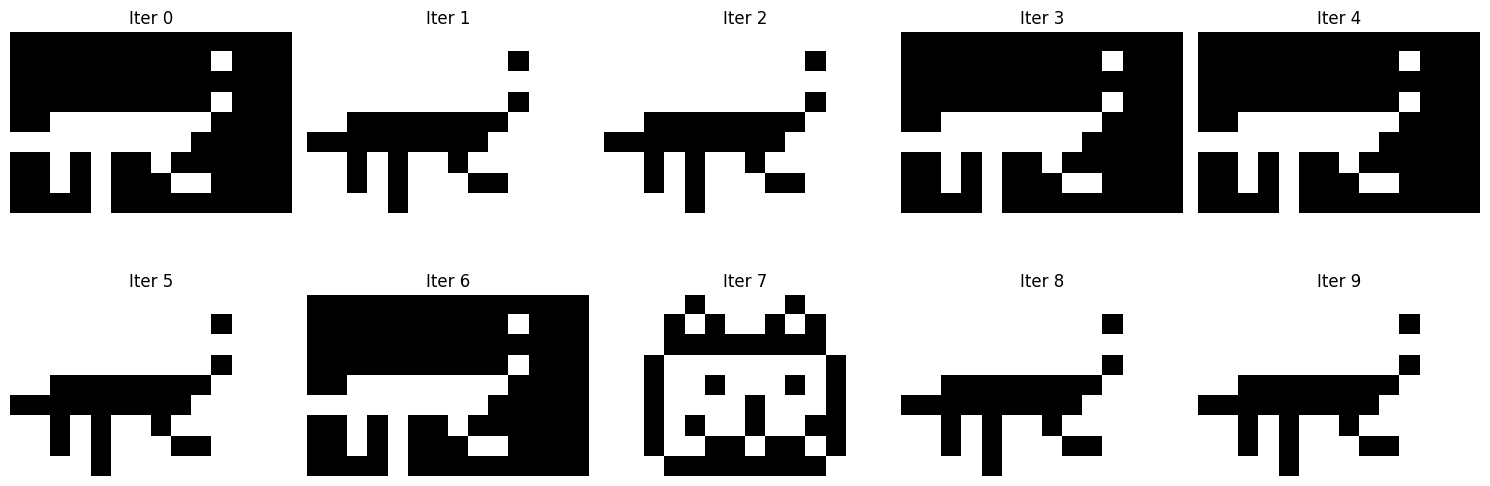

In [34]:
def experiment_random_input(net, nums_neurons, trials=10):
    randoms = []
    for _ in range(trials):
        rnd = np.random.choice([-1, 1], size=nums_neurons)
        rec, _ = net.run_sync(rnd)
        randoms.append(rec)
    return randoms


net_oji = HopfieldNet(nums_neurons)
net_oji.train_oja_symmetric(vecs)

net_hebb = HopfieldNet(nums_neurons)
net_hebb.train_hebb(vecs)

randoms_oji = experiment_random_input(net_oji, nums_neurons, trials=10)
randoms_hebb = experiment_random_input(net_hebb, nums_neurons, trials=10)

plot_iterations(randoms_oji, height, width)
plot_iterations(randoms_hebb, height, width)

### 5. Design a set of 5×5 vectors in which all patterns are stable.

In [58]:
vecs = np.loadtxt(f"data/orto.csv", delimiter=",")

# tricky w niektrórych zbiorach dlatego ustawiane ręcznie
height = 5
width = 5
nums_neurons = height * width

net_hebb = HopfieldNet(nums_neurons)
net_hebb.train_hebb(vecs)

for vec in vecs:
    recovered, _ = net_hebb.run_sync(vec)
    print("Stable:", np.array_equal(recovered, vec))

Stable: True
Stable: True
Stable: True
